# Problem Description
In this project, I am trying to alter regular photos into monet pieces of art. The goal is to use a generative adversarial network to train my generator to alter photos into monet images and to train a discriminator that can distinguish between real and fake monet paintings.  This is a model that has to neural network models playing back and forth off eachother. With this set up I can iterate until the discriminator has a hard time distinguish the real monet paintings from the generator created fake paintings. 
## Structure of Notebook
I have broken this notebook up into the main sections of Data, EDA, Model Architecture, Model Analysis and Conclusion. I will discuss my ideas, implementation and results for each section at the top before the code and figures for each section. 

## Scoring
This project is a kaggle competition and it scores the submissions. It is using MiFID (Memorization-informed Fréchet Inception Distance). The smaller the MiFID, the better the score. 
There are several scoring metrics for GAN's and I want to discuss each one briefly.
### IS
This is a score given to generated images based on two things. One is how well they align with a certain labeled class like 'cat'. The other is how well distributed the images are over classes. It is a checking to see image quality and variety, but it does not compare the generated images to real images.
### FID
This is the Frechet Inception Distance. It uses the same model as IS to reduce the image into its features, but instead of taking the information from the output layer, it takes an intermediate layer that boils down the features of the image. It then measures the real and generated images feature means and covariances which are multivariate gaussians at this point. It then compares them using the Frechet Distance to see how different they are. A lower score indicates better generated images.
### MiFID
This is similar to FID but multiplies FID by a memorization term. This memorization term is there to check if the generator is just learning to copy the training data or to actually learn a method that creates similar images that are not the same. 


# Data description
There are 300 training tfrec monet files and 7028 tfrec photo files to use for the GAN. I chose to use the tfrec files to learn how to process a different file type.
Upon further inspection of the tfrec data, there are three different features for each tfrec file. They are image, image name and target. For the monet files, the target is monet and for the photo files the target is photo. Both monet and photo files have unique image names. Their image data also has the same dimensions and is consistent across all tfrec files (256,256,3).  Here 256x256 are the pixel dimensions whereas the 3 is indicating RGB channels.

In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [31]:
#See what the .tfrec file looks like for monet
tfrecord_folder_monet = "monet_tfrec"
tfrecord_folder_photo = "photo_tfrec"

#Glob all files in folder together
tfrecord_path_monet = tf.io.gfile.glob(tfrecord_folder_monet + "/*.tfrec")
tfrecord_path_photo = tf.io.gfile.glob(tfrecord_folder_photo + "/*.tfrec")

dataset_monet = tf.data.TFRecordDataset(tfrecord_path_monet)
dataset_photo = tf.data.TFRecordDataset(tfrecord_path_photo)

def inspect_record(dataset):
    for raw_record in dataset.take(1):
        # Tf.train.Example() is for tfrecs to make readable
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())

        # Each example should have same features, print features
        print("\nFeatures in this record:")
        for key in example.features.feature:
            print(key)
        # Only need first record to understand structure so break
        break

#Look at structure for one photo file and one monet file
print("\nMonet Record")
inspect_record(dataset_monet)
print("\nPhoto Record")
inspect_record(dataset_photo)



Monet Record

Features in this record:
target
image_name
image

Photo Record

Features in this record:
target
image_name
image


That is nice, so I only need one feature description for both sets of records.

In [32]:
# Define the feature description matching the TFRecord structure
feature_description = {
    'target': tf.io.FixedLenFeature([],tf.string),
    'image_name': tf.io.FixedLenFeature([],tf.string),
    'image': tf.io.FixedLenFeature([], tf.string) 
}

# This function parses records into their features
def parse_function(record):
    parsed_record = tf.io.parse_single_example(record, feature_description)

    # Decode the JPEG image stored in image feature and normalize (0 to 1)
    image = tf.io.decode_jpeg(parsed_record['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0

    # Extract the target and image_name features
    target = parsed_record['target']
    image_name = parsed_record['image_name']
    
    return image, target, image_name

# Map the dataset with your parsing function to decode the records
parsed_dataset_monet = dataset_monet.map(parse_function)
parsed_dataset_photo = dataset_photo.map(parse_function)

In [33]:
#check photo and monets for unique dimensions
def get_dimensions(dataset):
    unique_shapes = set()
    for image, _, _ in dataset:
        unique_shapes.add(image.shape)
    return unique_shapes

print("Monet Dimensions", get_dimensions(parsed_dataset_monet))
print("Photo Dimensions", get_dimensions(parsed_dataset_photo))


Monet Dimensions {TensorShape([256, 256, 3])}
Photo Dimensions {TensorShape([256, 256, 3])}


# Exploratory Data Analysis

### Random Sample of Images
I took a few images from the monet data and the photo data to understand what each look like. The monet images are very distinct and have a unique style because they are all from the same painter. The photos sampled are natural places and look very different compared to the monet images. 

### Distribution of RGB values
This shows a distribution of RGB values per pixel in the photos dataset (Left) and the Monet dataset (Right). It is clear that the photos are in general darker than the monets since they have a much greater number of low valued pixels indicating darkness. The monets are full of color and do not have many fully dark or fully white spots. It appears green values for each pixel in the photos are dominant in the 50-150 range whereas the green values are dominant in the monets from the 150-200 range. It is interesting to see the color dominance differences in Monets vs Photos.  

### Brightness graph
Given the information above and general amount of darkness in the photos compared to monets looking at 0-10 valued pixels, I was assuming that monets would be brighter than the photos. It was confirmed by this graph and showed a distinct cluster of monets higher on the brightness scale compared to photos lower on the brightness scale. I'd assume this would be one easy target for the model to just increase the photos brightness to get closer to the Monet images. 

### Examine characteristics of just the monets




EDA goes above and beyond expectations: for example, in addition to picking a few sample images from each class, displaying them, and describing any findings, the learner includes several other histograms, appropriate visualizations, and detailed analysis of the dataset.

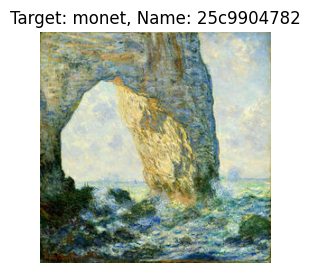

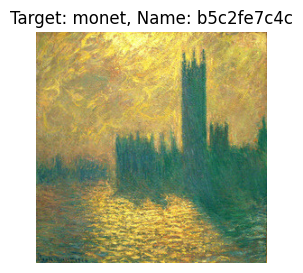

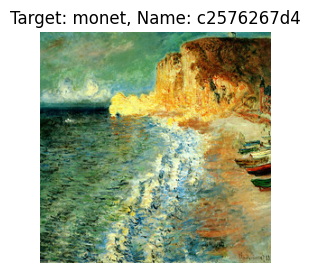

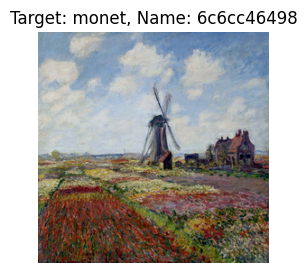

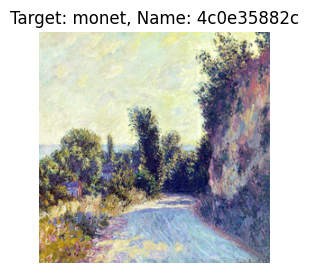

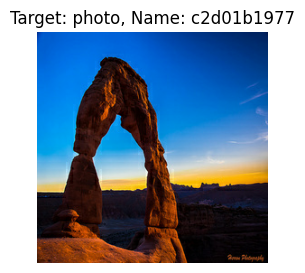

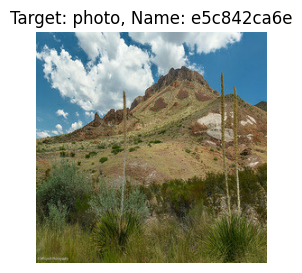

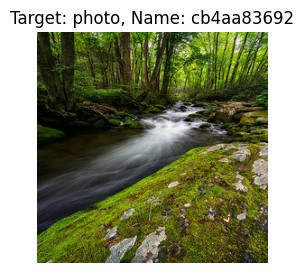

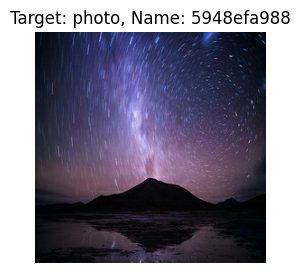

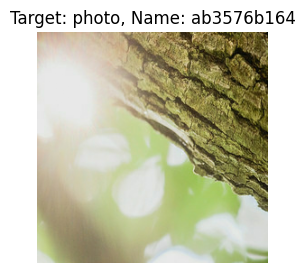

In [30]:
#takes 5 images from dataset and plots them
def show_images(dataset):
    for image, target, image_name in dataset.take(5):
        plt.figure(figsize=(3, 3))
        plt.imshow(image.numpy())
        plt.title(f"Target: {target.numpy().decode('utf-8')}, Name: {image_name.numpy().decode('utf-8')}")
        plt.axis('off')
        plt.show()

#show 5 images for photos and monets
show_images(parsed_dataset_monet)
show_images(parsed_dataset_photo)

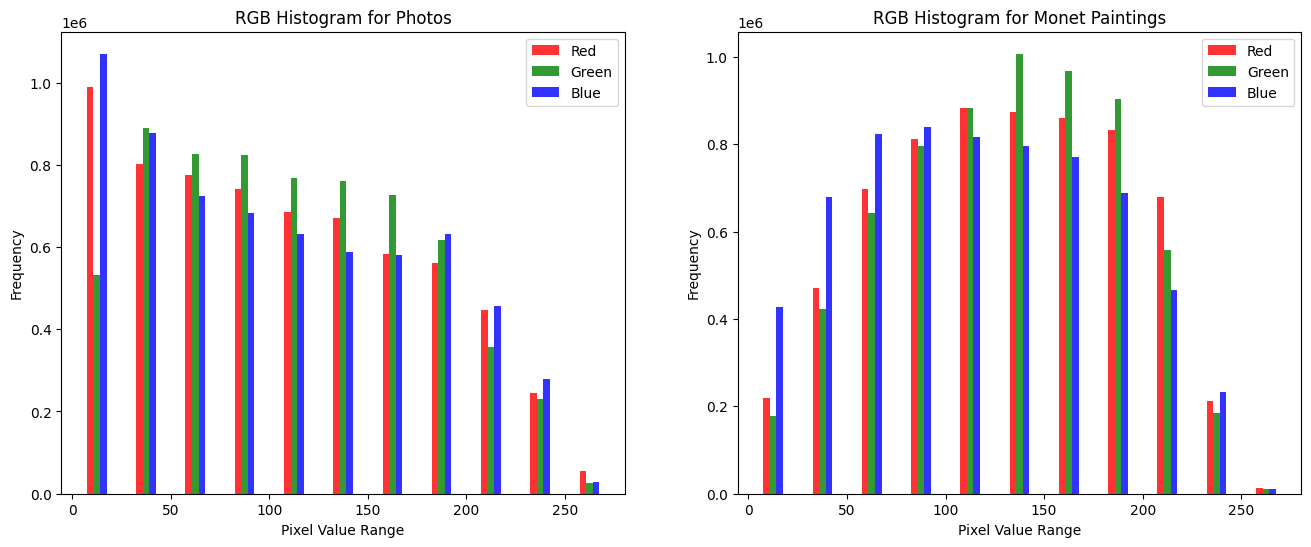

In [40]:
#this function takes a dataset and number of samples from that data set and adds pixel values for RGB to running totals
def aggregate_histograms(dataset, num_samples=100):
    # make bins of 25
    bin_edges = np.arange(0, 276, 25)  # 276 to include last few pixels 250-255
    num_bins = len(bin_edges) - 1
    
    total_r_hist = np.zeros(num_bins)
    total_g_hist = np.zeros(num_bins)
    total_b_hist = np.zeros(num_bins)
    
    # Iterate over images in the dataset
    for image, _, _ in dataset.take(num_samples):
        # Make sure it is 0-255, not 0-1
        image_np = image.numpy() * 255.0
        image_np = image_np.astype(np.uint8)
        
        # Getting each color from image_np
        r_hist, _ = np.histogram(image_np[:, :, 0], bins=bin_edges)
        g_hist, _ = np.histogram(image_np[:, :, 1], bins=bin_edges)
        b_hist, _ = np.histogram(image_np[:, :, 2], bins=bin_edges)
        
        total_r_hist += r_hist
        total_g_hist += g_hist
        total_b_hist += b_hist
        
    return total_r_hist, total_g_hist, total_b_hist, bin_edges


num_samples = 100
# Aggregate for Photos and Monet painting datasets
photo_r_hist, photo_g_hist, photo_b_hist, bin_edges = aggregate_histograms(parsed_dataset_photo, num_samples)
monet_r_hist, monet_g_hist, monet_b_hist, _ = aggregate_histograms(parsed_dataset_monet, num_samples)

import matplotlib.pyplot as plt

# Get centers of each bin and set bar_width
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bar_width = 10

# Create two subplots in one figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Axes[#] gives subplot to work with axis[0] for photos and axis[1] for Monets
axes[0].bar(bin_centers - bar_width/3, photo_r_hist, width=bar_width/3, color='red', alpha=0.8, label='Red')
axes[0].bar(bin_centers, photo_g_hist, width=bar_width/3, color='green', alpha=0.8, label='Green')
axes[0].bar(bin_centers + bar_width/3, photo_b_hist, width=bar_width/3, color='blue', alpha=0.8, label='Blue')
axes[0].set_title("RGB Histogram for Photos")
axes[0].set_xlabel("Pixel Value Range")
axes[0].set_ylabel("Frequency")
axes[0].legend()

axes[1].bar(bin_centers - bar_width/3, monet_r_hist, width=bar_width/3, color='red', alpha=0.8, label='Red')
axes[1].bar(bin_centers, monet_g_hist, width=bar_width/3, color='green', alpha=0.8, label='Green')
axes[1].bar(bin_centers + bar_width/3, monet_b_hist, width=bar_width/3, color='blue', alpha=0.8, label='Blue')
axes[1].set_title("RGB Histogram for Monet Paintings")
axes[1].set_xlabel("Pixel Value Range")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.show()


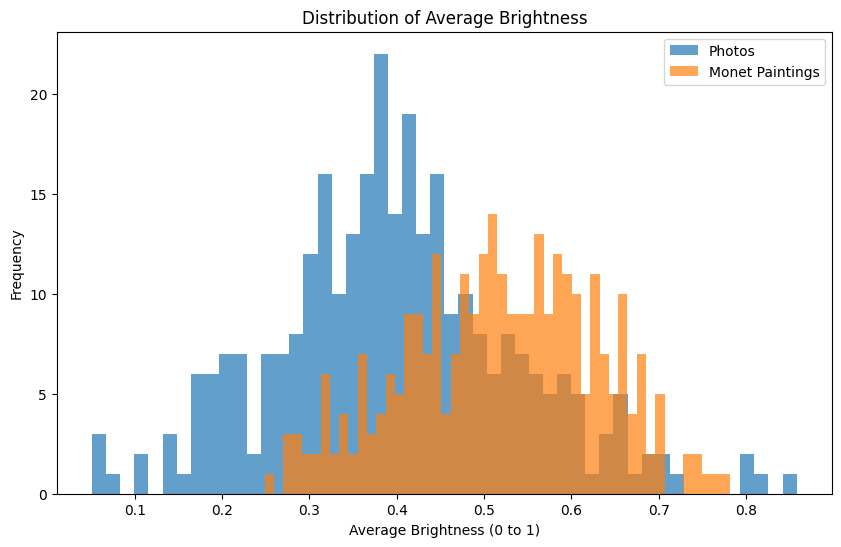

In [ ]:
#plot average brightness of images vs Monets: based on the above data I'd expect the Monets to be brighter

#takes a dataset with images and calculates the images average brightness and adds it to the brightness values array
def compute_average_brightness(dataset, num_samples=100):
    brightness_values = []
    for image, _, _ in dataset.take(num_samples):
        # Convert RGB image to grayscale. Converts each pixel to one brightness value from RGB values
        grayscale_image = tf.image.rgb_to_grayscale(image)
        # Compute the average brightness as the mean of all pixel intensities.
        avg_brightness = tf.reduce_mean(grayscale_image)
        brightness_values.append(avg_brightness.numpy())
    return brightness_values

# Monet and Photo brightness for 100 samples
photo_brightness = compute_average_brightness(parsed_dataset_photo, num_samples=300)
monet_brightness = compute_average_brightness(parsed_dataset_monet, num_samples=300)

# Plot the brightness
plt.figure(figsize=(10, 6))

# Plot histograms for both datasets on the same graph.
plt.hist(photo_brightness, bins=50, alpha=0.7, label="Photos")
plt.hist(monet_brightness, bins=50, alpha=0.7, label="Monet Paintings")

plt.xlabel("Average Brightness (0 to 1)")
plt.ylabel("Frequency")
plt.title("Distribution of Average Brightness")
plt.legend()
plt.show()


# Model Architecture
To receive full points, the learner needs to address the three questions below:
Does it describe the model architecture and explain why the learner believes a specific architecture/loss function is suitable for the problem? 
Did the learner tune the hyperparameters? 
Did the learner compare multiple architectures/loss functions?
Note, when you evaluate, don't just base your score on the complexity of the model/technique or performance of the model alone. Base your score on how the learner demonstrates understanding by explaining the concepts and why they chose particular methods/techniques.


 Uses one architecture and explanation for choosing that particular architecture/loss function and hyperparameter tuning and compares several architectures/loss functions. 

Results and Analysis 
To receive full points for this section, the author needs to address the following:
Results
Does it include results in the form of tables, figures, etc.? 
Analysis 
Does it include analysis of results:
the reasoning of why something worked well or why it didn't work
description of troubleshooting steps.
a hyperparameter optimization procedure summary.
35 pts
Includes all of the following:  result tables or visualizations, conclusion/summary for hyperparameter tuning, reasoning on why some models or hyperparameters work well or why they do not, and explains any troubleshooting procedure.

Includes all of the following: basic reiteration of result and discussion of learning and takeaways and discussion of why something didn’t work, and suggestions for ways to improve.